<a href="https://colab.research.google.com/github/ctclumak/posts/blob/master/Machine_Learning_Model_Selections_and_Evaluations_Boston_Housing_Market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [234]:
import os, tarfile, urllib
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold,cross_val_score
from numpy import absolute,mean, std
from sklearn.metrics import mean_squared_error,r2_score


In [235]:
from sklearn.datasets import load_boston
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [236]:
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [237]:
#the target value MEDV is missing from the data. 
#We create a new column of target values and add it to the dataframe.
boston['MEDV'] = boston_dataset.target
boston.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


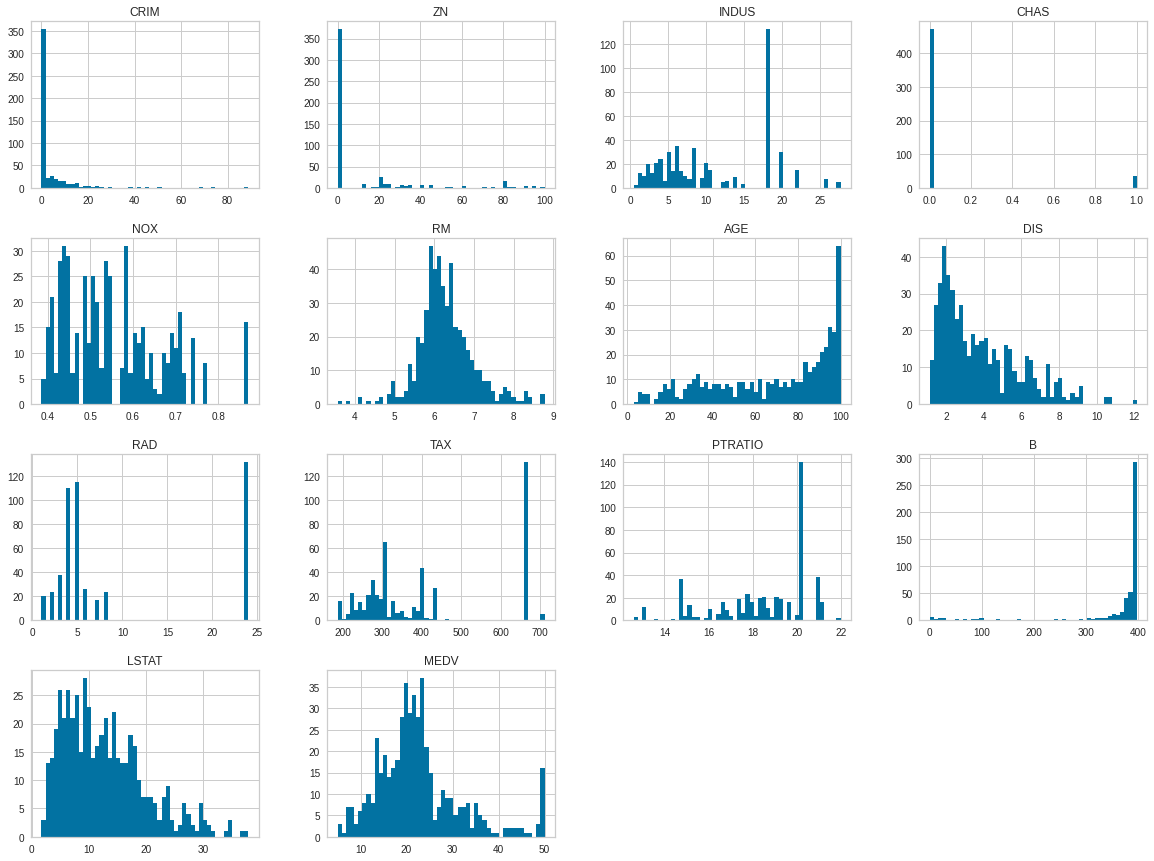

In [238]:
boston.hist(bins=50, figsize=(20,15))
plt.show()


- a: RM and MEDV have the closest shape to normal distributions.
- b: AGE is skewed to the left and LSTAT is skewed to the right (this may seem counter intuitive but skew is defined in terms of where the mean is positioned in relation to the max).
- c: For TAX, we find a large amount of the distribution is around 700. This is also evident from the scatter plots

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


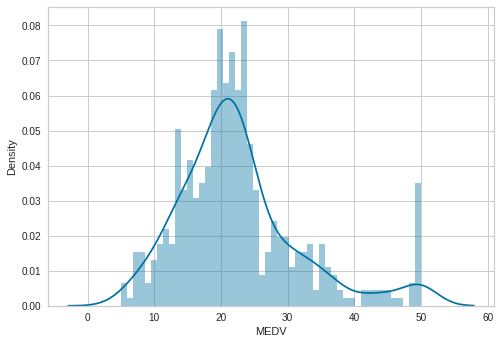

In [239]:
sns.distplot(boston["MEDV"], bins=50)
display()

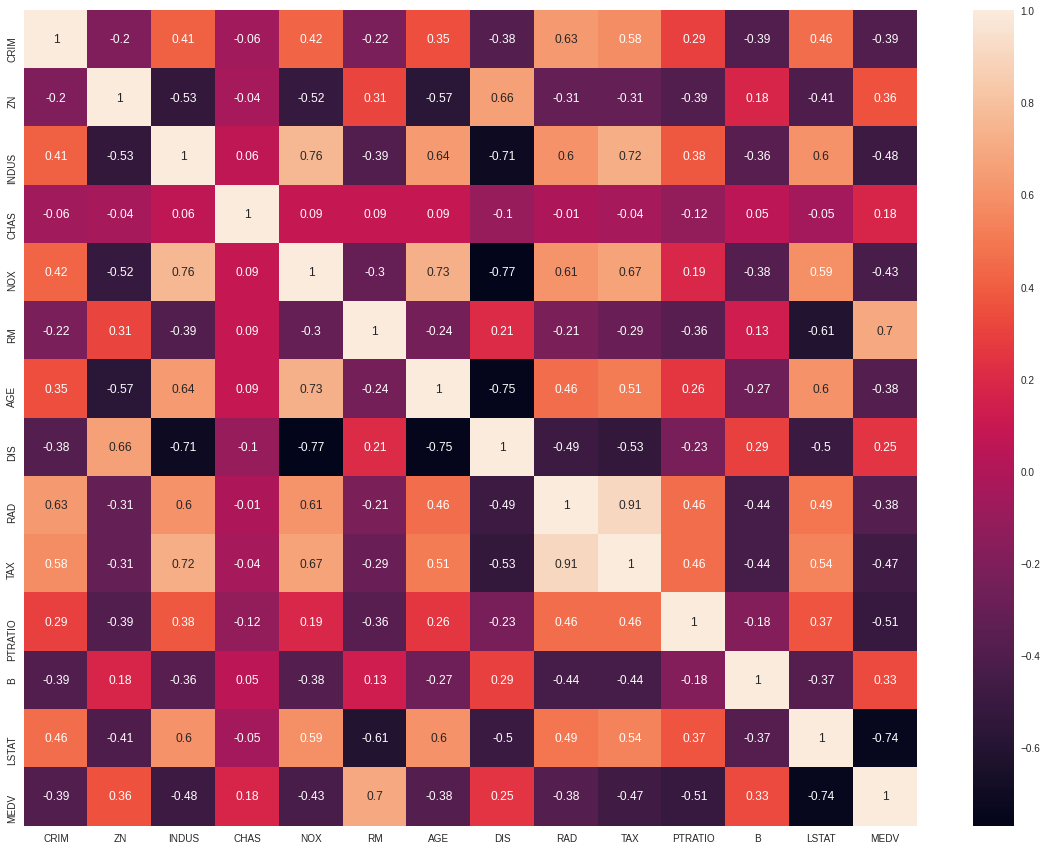

In [240]:
correlation_matrix = boston.corr().round(2)

fig, ax = plt.subplots(figsize=(20,15))

sns.heatmap(data=correlation_matrix, annot=True)

In [241]:
correlation_matrix["MEDV"].sort_values(ascending=False)

MEDV       1.00
RM         0.70
ZN         0.36
B          0.33
DIS        0.25
CHAS       0.18
RAD       -0.38
AGE       -0.38
CRIM      -0.39
NOX       -0.43
TAX       -0.47
INDUS     -0.48
PTRATIO   -0.51
LSTAT     -0.74
Name: MEDV, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


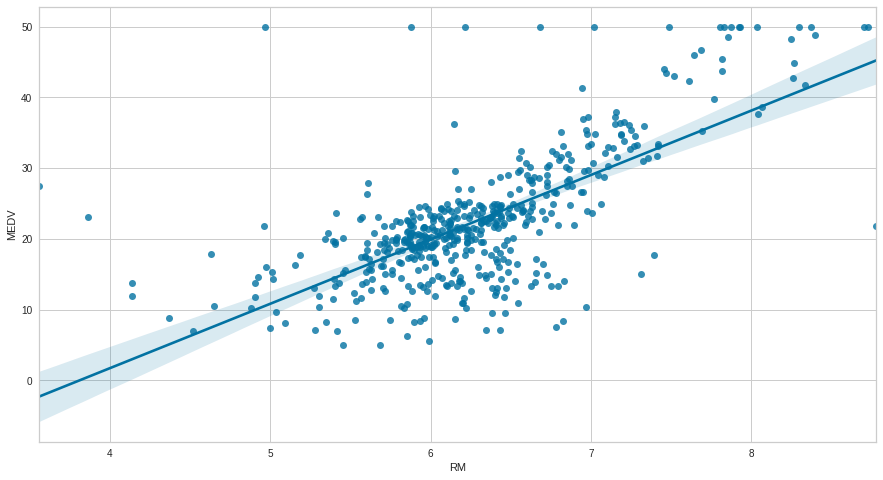

In [242]:
fig, ax = plt.subplots(figsize=(15,8))
sns.regplot("RM", "MEDV", boston)



In [243]:
#remove all those columns that are of no interest in predicting the target variable.
for col in ["CHAS", "B", "ZN", "RAD"]:
 del boston[col]
X = boston.drop("MEDV", axis=1)
Y = boston["MEDV"].copy()


## Evaluate the model using cross validation to find out the best model
- **The Mean Absolute Error (or MAE)** is the average of the absolute differences between predictions and actual values. It gives an idea of how wrong the predictions were.
- **The Mean Squared Error (or MSE)** is much like the mean absolute error in that it provides a gross idea of the magnitude of error. It is something we want to minimize.
- **The R^2 (or R Squared)** metric provides an indication of the goodness of fit of a set of predictions to the actual values. In statistical literature, this measure is called the coefficient of determination.

In [244]:
# determine categorical and numerical features
numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
# define the data preparation for the columns
t = [('cat', OneHotEncoder(), categorical_ix), ('num', StandardScaler(), numerical_ix)]
col_transform = ColumnTransformer(transformers=t)

#create a train and test set
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)


In [245]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


# Spot Check Algorithms
models = []
models.append(('Linear', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('DecisionTree', DecisionTreeRegressor()))
models.append(('RandomForest', RandomForestRegressor()))
models.append(('SVR', SVR(kernel = 'rbf')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
  # define the data preparation and modeling pipeline
  pipeline = Pipeline(steps=[('prep',col_transform), ('m', model)])
  cv = KFold(n_splits=10, shuffle=True, random_state=1)
  cv_results = cross_val_score(model,X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
  cv_results = absolute(cv_results)
  results.append(cv_results)
  names.append(name)
  print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))


Linear: 3.598611 (0.535752)
Ridge: 3.598831 (0.532009)
Lasso: 3.944717 (0.428866)
DecisionTree: 3.424604 (0.729148)
RandomForest: 2.387844 (0.296648)
SVR: 5.626455 (0.767736)


## Make & Evaluate Predictions using the best model you found

In [246]:
#Make Predictions
model = RandomForestRegressor(random_state=1, max_depth=10)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

#Evaluate Predictions
rmse = (np.sqrt(mean_squared_error(y_test, predictions)))
r2 = r2_score(y_test, predictions)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

The model performance for testing set
--------------------------------------
RMSE is 2.867661217980434
R2 score is 0.8878623124743097




In [247]:
print("Training set score: {:.2f}".format(model.score(X_train, y_train)))
print("Test set score: {:.2f}".format(model.score(X_test, y_test)))




Training set score: 0.98
Test set score: 0.89


## Grid Search

In [248]:
from sklearn.model_selection import GridSearchCV
param_grid = [
{'n_estimators': [3, 30, 50,100], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(X, Y)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

In [249]:
print("Best params:\n{}\n".format(grid_search.best_params_))



Best params:
{'max_features': 4, 'n_estimators': 50}



/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


PredictionError(alpha=0.75,
                ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f8b5d3ee7b8>,
                bestfit=True, identity=True, model=None, shared_limits=True)

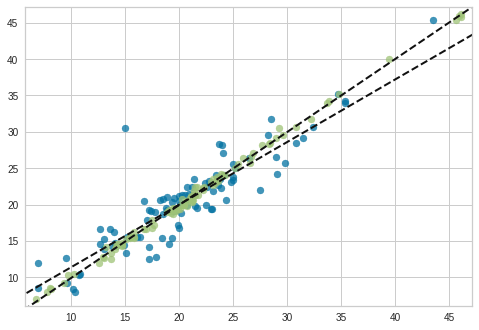

In [250]:
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import PredictionError


# Instantiate the linear model and visualizer
model = RandomForestRegressor()
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.score(X_test, predictions) 
visualizer                # Finalize and render the figure